<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl
import json

from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io
from google.colab import drive


WEIGHTSANDBIASES = True
DOWNLOAD = False
CROPPING = False
SEGMENTATION = True
CLAHE = False

# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'



drive.mount('/content/drive')


if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

  !kaggle datasets download -d "tschandl/ham10000-lesion-segmentations"

  !unzip -o ham10000-lesion-segmentations.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# !mkdir -p ~/.kaggle
# !mv /content/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json


!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [23]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [24]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __setmasks__(self,masks):
      self.masks = masks

  def __getmask__(self,i):
      return self.masks[i]

  def __lenmasks__(self):
    return len(self.masks)

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getpath__(self,index):
    return self.paths[index]

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if SEGMENTATION:
        mask = cv2.imread(self.masks[index], cv2.IMREAD_GRAYSCALE)
        _, mask_binaria = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        image = cv2.bitwise_and(image, image, mask=mask_binaria)

        non_black_pixels = np.where(image > 0)

        x_min, x_max = np.min(non_black_pixels[1]), np.max(non_black_pixels[1])
        y_min, y_max = np.min(non_black_pixels[0]), np.max(non_black_pixels[0])

        marge = 10
        if ((x_min - marge) >= 0):
            x_min = x_min - marge
        if ((x_max + marge) <= 224):
            x_max = x_max + marge

        if CROPPING:
          image = image[y_min:y_max, x_min:x_max]

        # print(cropped_image.shape)
        image = cv2.resize(image, (299, 299), interpolation=cv2.INTER_CUBIC)

      #preprocessament
      if CLAHE:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        lab_clahe = cv2.merge((l_clahe, a, b))
        image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)




      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [25]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [26]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)

  mask_files = sorted(glob('/content/sample_data/HAM10000_segmentations_lesion_tschandl/*'))

  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  mask_path_dict = {os.path.splitext(os.path.basename(x))[0].replace('_segmentation', ''): x for x in mask_files}

  #print(mask_path_dict)

  #{'ISIC_0024306_segmentation': '/content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0024306_segmentation.png'

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['mask_path'] = metadates['image_id'].map(mask_path_dict.get)

  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)

  if SEGMENTATION:

    train_data.__setmasks__(X_train['mask_path'].to_numpy())
    test_data.__setmasks__(X_test['mask_path'].to_numpy())
    validation_data.__setmasks__(X_val['mask_path'].to_numpy())

  return train_data, validation_data,test_data


In [27]:
def get_weights():

  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}

  valors = metadates['dx'].value_counts()
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1

  weights = weights / weights.sum()

  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]) ,weights

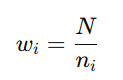

In [28]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [29]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  # elif numero_model == 1:
  #   resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
  #   resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

  #   pos_weight = torch.tensor(weights,device = device)
  #   loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  #   return resnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    googlenet = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    googlenet.aux_logits = False

    num_features = googlenet.fc.in_features
    googlenet.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenet,loss_fn

  elif numero_model == 3:
    efficientnet = models.efficientnet_b1(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = efficientnet.classifier[1].in_features
    efficientnet.classifier[1] = nn.Linear(in_features=num_features, out_features=1)

    return efficientnet,loss_fn

  elif numero_model == 4:

    alexnetmulticlass = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    alexnetmulticlass.classifier[6] = nn.Linear(in_features=4096, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return alexnetmulticlass,loss_fn

  # elif numero_model == 6:

  #   resnetmulticlass = models.resnet50(weights="IMAGENET1K_V1")
  #   num_features = resnetmulticlass.fc.in_features
  #   resnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

  #   weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
  #   loss_fn = nn.CrossEntropyLoss(weight=weights)

  #   return resnetmulticlass,loss_fn

  elif numero_model == 5:
    resnetmulticlass152 = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetmulticlass152.fc.in_features
    resnetmulticlass152.fc = nn.Linear(in_features=num_features, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return resnetmulticlass152,loss_fn

  elif numero_model == 6:

    googlenetmulticlass = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = googlenetmulticlass.fc.in_features
    googlenetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

    return googlenetmulticlass,loss_fn

  elif numero_model == 7:

    efficientnetmulticlass = models.efficientnet_b1(weights='IMAGENET1K_V1')

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = efficientnetmulticlass.classifier[1].in_features
    efficientnetmulticlass.classifier[1] = nn.Linear(in_features=num_features, out_features=7)

    return efficientnetmulticlass,loss_fn



In [30]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [31]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        input_img = input_img.to(device)
        output = model(input_img.to(device))

        if isinstance(output, tuple) or hasattr(output, 'logits'):
                output = output.logits

        #print(output.shape[1])

        if output.shape[1] > 1: #multiclass
          a = 1
        else: #binary
          target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
          target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

        if output.shape[1] > 1:
          target = target.to(device)
          loss = loss_fn(output, target)
        else:
          target = target.to(device)
          loss = loss_fn(output, target.float())


        if output.shape[1] > 1:
          output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
          output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
          output = output.cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)   #funció sigmoide per al cas binari
          output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,average='weighted',zero_division=1)
        train_recall += recall_score(target,output,average='weighted',zero_division=1)
        train_precision += precision_score(target,output,average='weighted',zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [32]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):

            input_img = input_img.to(device)
            output = model(input_img)

            if isinstance(output, tuple) or hasattr(output, 'logits'):
                output = output.logits


            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari
              output = (output.cpu().detach().numpy() > 0.5).astype(int)


            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,average='weighted',zero_division=1)
            val_recall += recall_score(target,output,average='weighted',zero_division=1)
            val_precision += precision_score(target,output,average='weighted',zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [33]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)


  interval = 5
  requerit = 0.010
  last_loss = float('inf')

  epoch_number = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)
      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if interval > 0:
        interval -= 1

      if interval == 0:
        if last_loss - requerit < train_loss:
            print("Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!")
            break
        else:
          interval = 5
          last_loss = train_loss

  return model

In [34]:
def test(model,dataloader,weights_dir,loss_fn,device):

  model.load_state_dict(torch.load(weights_dir))

  test_acc = 0
  test_f1 = 0
  test_recall = 0
  test_precision = 0
  test_loss = 0

  json_obj = []

  model.eval()

  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(dataloader):

            input_img = input_img.to(device)
            output = model(input_img)

            if isinstance(output, tuple) or hasattr(output, 'logits'):
                output = output.logits

            dades = {}

            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = (output.cpu().detach().numpy() > 0.5).astype(int)

            dades["target"] = target.cpu().detach().tolist()

            target = target.cpu().detach().numpy()

            dades["top1-accuracy"] = accuracy_score(target,output)
            test_acc  += dades["top1-accuracy"]
            dades["f1-score"] = f1_score(target,output,average='weighted',zero_division=1)
            test_f1 += dades["f1-score"]
            dades["recall"] = recall_score(target,output,average='weighted',zero_division=1)
            test_recall += dades["recall"]
            dades["precision"] = precision_score(target,output,average='weighted',zero_division=1)
            test_precision += dades["precision"]

            dades["loss"] = loss.item()
            test_loss += dades["loss"]

            json_obj.append(dades)


  return json_obj

In [35]:
def veure_imatges(train_data):
  for i in range(len(train_data)):
    path = train_data.__getpath__(i)
    clean_img = cv2.imread(path)
    mean, std = cv2.meanStdDev(clean_img)

    clean_img = cv2.resize(clean_img, (224, 224))
    clean_img = torch.tensor(clean_img).permute(2, 0, 1)  # Convert to (C, H, W)

    print(clean_img.shape)

    imatge,label = train_data.__getitem__(i)
    print(imatge.shape)
    std = std.flatten()
    mean = mean.flatten()
    imatge = imatge * (std[:, None, None]) + (mean[:, None, None])

    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    clean_img = clean_img.permute(1, 2, 0).numpy() #clean_img no es un torch

    combined_image = np.concatenate((img_numpy, clean_img), axis=1)
    cv2_imshow(combined_image)

    time.sleep(5)
    clear_output(wait=True)

In [36]:
from itertools import product
BINARY = False #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet152':1,'inceptionv3':2,'efficientnetb1':3,'alexnetmulticlass':4,'resnet152multiclass':5,'inceptionv3multiclass':6,'efficientnetb1multiclass':7}
img_sizes = {'alexnet': 224,'resnet152':224,'inceptionv3':299,'efficientnetb1':224,'alexnetmulticlass':224,'resnet152multiclass':224,'inceptionv3multiclass':299,'efficientnetb1multiclass':224}

nom_model = 'inceptionv3multiclass'
MODEL = architectures[nom_model]

TRAINING = 0.80
VALIDATION = 0.10
TESTING = 0.10
SIZE = img_sizes[nom_model]


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
DISTRIBUTIONS = None

if SEGMENTATION == False:
  transform = transforms.Compose([
      transforms.Resize((SIZE,SIZE)),
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std)
  ])

  transform_training = transforms.Compose([
      transforms.Resize((SIZE,SIZE)),
      transforms.RandomHorizontalFlip(p=0.3),
      transforms.RandomVerticalFlip(p=0.3),
      transforms.RandomRotation(degrees=20),
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std),
  ])
else:
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std)
  ])

  transform_training = transforms.Compose([
      transforms.RandomHorizontalFlip(p=0.3),
      transforms.RandomVerticalFlip(p=0.3),
      transforms.RandomRotation(degrees=20),
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std),
  ])

CLAHE = False
train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)


EPOCHS = 60
batch_size = 32

binary_weights, multiple_weights = get_weights()

if MODEL < 4:
  weights = binary_weights
else:
  weights = multiple_weights

print(weights)
learning_rate  = 1e-5


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

model,loss_fn = tria_model(MODEL,weights)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)

projectes = ['Ham10000-AlexnetBinary','Ham1000-Resnet152Binary','Ham10000-Inceptionv3Binary','Ham10000-EfficientNetB1Binary',
              'Ham10000-AlexnetMulticlass','Ham10000Resnet152Multiclass','Ham10000-Inceptionv3Multiclass','Ham10000-EfficientNetB1Multiclass']

if WEIGHTSANDBIASES:
    wandb.init(
            project=projectes[MODEL],
            config={
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "weights":weights,
                "CLAHE": CLAHE,
                })
    config = wandb.config
    print(config)


parametres_training = {
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "testsize":len(test_loader),
                "testdist": TESTING,
                "loss_weights":str(weights),
                "SEGMENTATION": SEGMENTATION,
                "CROPPING": CROPPING,
                "img_size": SIZE,
                "random_state": 42,
                "WeightsAndBiases": wandb.run.get_url(),
                "data_augmentation": str(transform_training)
}

carpeta_drive = '/content/drive/MyDrive/Runs/' + projectes[MODEL]
os.makedirs(carpeta_drive, exist_ok=True) #cream la carpeta si no existeix

current_runs = len([d for d in os.listdir(carpeta_drive) if os.path.isdir(os.path.join(carpeta_drive, d))]) #número d'execucions fetes de cada model

#cada execució tindrà la seva carpeta numerada

json_object = json.dumps(parametres_training,indent = 2)

#cream la carpeta de l'execució

num_execucio = str(current_runs)
carpeta_execucio = carpeta_drive+"/"+ num_execucio
os.makedirs(carpeta_execucio,exist_ok=True)

#afegim la informació d'entrenament a la carpeta
with open(carpeta_execucio+"/training_info.json", "w") as outfile:
  outfile.write(json_object)

#guardam els pesos a la carpeta de drive
best_model = execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+num_execucio+'.pt'
torch.save(model.state_dict(), carpeta_pesos )

#també guardam els resultats del test a la carpeta de drive
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+str(current_runs)+'.pt'

resultats = test(model,test_loader,carpeta_pesos,loss_fn,device)

with open(carpeta_execucio+"/testing_info.json", "w") as outfile:
    json.dump(resultats, outfile, indent=3)


wandb.finish()

[0.00657042 0.03958192 0.04008614 0.08570948 0.13472377 0.31024417
 0.3830841 ]


{'epochs': 60, 'batch_size': 32, 'lr': 1e-05, 'trsize': 251, 'trdist': 0.8, 'vsize': 32, 'vdist': 0.1, 'weights': [0.0065704208816761995, 0.03958191555403316, 0.04008614377765142, 0.08570947862186559, 0.13472376761969088, 0.31024416909604874, 0.383084104449034], 'CLAHE': False}


  0%|          | 0/60 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 1.7697009603340788
Accuracy train epoch: 1  train_acc: 0.3324882289025715
F1 train epoch: 1  train_f1: 0.39381752961267663
Recall train epoch: 1  train_recall: 0.3324882289025715


Pèrdua validació epoch: 1  val_loss: 1.5111085530370474
Accuracy val epoch: 1  val_acc: 0.5509765625
F1 val epoch: 1  val_f1: 0.609035181461879
Recall val epoch: 1  val_recall: 0.5509765625
Recall val epoch: 1  val_precision: 0.7867395988662073


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 1.321127954469734
Accuracy train epoch: 2  train_acc: 0.55658049619703
F1 train epoch: 2  train_f1: 0.6181893669056195
Recall train epoch: 2  train_recall: 0.55658049619703


Pèrdua validació epoch: 2  val_loss: 1.1044253520667553
Accuracy val epoch: 2  val_acc: 0.63125
F1 val epoch: 2  val_f1: 0.6764953632685393
Recall val epoch: 2  val_recall: 0.63125
Recall val epoch: 2  val_precision: 0.7953444868923082


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 1.0415890717886358
Accuracy train epoch: 3  train_acc: 0.6286445128576602
F1 train epoch: 3  train_f1: 0.6829451673216275
Recall train epoch: 3  train_recall: 0.6286445128576602


Pèrdua validació epoch: 3  val_loss: 0.9250269252806902
Accuracy val epoch: 3  val_acc: 0.6916015625
F1 val epoch: 3  val_f1: 0.728846925305072
Recall val epoch: 3  val_recall: 0.6916015625
Recall val epoch: 3  val_precision: 0.817894896484973


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.8989094349730062
Accuracy train epoch: 4  train_acc: 0.6692321622600507
F1 train epoch: 4  train_f1: 0.7171409324765401
Recall train epoch: 4  train_recall: 0.6692321622600507


Pèrdua validació epoch: 4  val_loss: 0.8757624253630638
Accuracy val epoch: 4  val_acc: 0.6873046875
F1 val epoch: 4  val_f1: 0.7257858534284527
Recall val epoch: 4  val_recall: 0.6873046875
Recall val epoch: 4  val_precision: 0.8236623768526069


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.7980879364735577
Accuracy train epoch: 5  train_acc: 0.6907483701557406
F1 train epoch: 5  train_f1: 0.7349892423819235
Recall train epoch: 5  train_recall: 0.6907483701557406


Pèrdua validació epoch: 5  val_loss: 0.8354913918301463
Accuracy val epoch: 5  val_acc: 0.7388671875
F1 val epoch: 5  val_f1: 0.7659884028248891
Recall val epoch: 5  val_recall: 0.7388671875
Recall val epoch: 5  val_precision: 0.8373153868601745


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.7163876101552727
Accuracy train epoch: 6  train_acc: 0.7121627127852227
F1 train epoch: 6  train_f1: 0.7523756643894786
Recall train epoch: 6  train_recall: 0.7121627127852227


Pèrdua validació epoch: 6  val_loss: 0.7615501135587692
Accuracy val epoch: 6  val_acc: 0.726171875
F1 val epoch: 6  val_f1: 0.7566139056236081
Recall val epoch: 6  val_recall: 0.726171875
Recall val epoch: 6  val_precision: 0.8351159498201692


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.6816116843328058
Accuracy train epoch: 7  train_acc: 0.7296156283955089
F1 train epoch: 7  train_f1: 0.7670635392027892
Recall train epoch: 7  train_recall: 0.7296156283955089


Pèrdua validació epoch: 7  val_loss: 0.7329063802026212
Accuracy val epoch: 7  val_acc: 0.7443359375
F1 val epoch: 7  val_f1: 0.772450758686753
Recall val epoch: 7  val_recall: 0.7443359375
Recall val epoch: 7  val_precision: 0.8406722987490453


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.5925176481445472
Accuracy train epoch: 8  train_acc: 0.7418281419775443
F1 train epoch: 8  train_f1: 0.776341787966459
Recall train epoch: 8  train_recall: 0.7418281419775443


Pèrdua validació epoch: 8  val_loss: 0.7229572990909219
Accuracy val epoch: 8  val_acc: 0.764453125
F1 val epoch: 8  val_f1: 0.7913280710209907
Recall val epoch: 8  val_recall: 0.764453125
Recall val epoch: 8  val_precision: 0.861407193965916


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.5604877450551645
Accuracy train epoch: 9  train_acc: 0.7542557044549076
F1 train epoch: 9  train_f1: 0.7894880879756399
Recall train epoch: 9  train_recall: 0.7542557044549076


Pèrdua validació epoch: 9  val_loss: 0.735024151392281
Accuracy val epoch: 9  val_acc: 0.730078125
F1 val epoch: 9  val_f1: 0.7631657870168564
Recall val epoch: 9  val_recall: 0.730078125
Recall val epoch: 9  val_precision: 0.8454353649235248


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.5310667769248743
Accuracy train epoch: 10  train_acc: 0.760741126403477
F1 train epoch: 10  train_f1: 0.7943693579625263
Recall train epoch: 10  train_recall: 0.760741126403477


Pèrdua validació epoch: 10  val_loss: 0.6920868777669966
Accuracy val epoch: 10  val_acc: 0.7791015625
F1 val epoch: 10  val_f1: 0.8004356605523454
Recall val epoch: 10  val_recall: 0.7791015625
Recall val epoch: 10  val_precision: 0.8580966164314111


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.47318660346160374
Accuracy train epoch: 11  train_acc: 0.7800389351684172
F1 train epoch: 11  train_f1: 0.8097461416587333
Recall train epoch: 11  train_recall: 0.7800389351684172


Pèrdua validació epoch: 11  val_loss: 0.7118399096652865
Accuracy val epoch: 11  val_acc: 0.7865234375
F1 val epoch: 11  val_f1: 0.8071992433620266
Recall val epoch: 11  val_recall: 0.7865234375
Recall val epoch: 11  val_precision: 0.8629693337156639


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.4420786865678916
Accuracy train epoch: 12  train_acc: 0.7858905287939152
F1 train epoch: 12  train_f1: 0.8152027404523122
Recall train epoch: 12  train_recall: 0.7858905287939152


Pèrdua validació epoch: 12  val_loss: 0.6674477881751955
Accuracy val epoch: 12  val_acc: 0.773828125
F1 val epoch: 12  val_f1: 0.7984677656820683
Recall val epoch: 12  val_recall: 0.773828125
Recall val epoch: 12  val_precision: 0.867422016924871


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.4345749080834161
Accuracy train epoch: 13  train_acc: 0.7874071894241217
F1 train epoch: 13  train_f1: 0.8167800551849386
Recall train epoch: 13  train_recall: 0.7874071894241217


Pèrdua validació epoch: 13  val_loss: 0.6366693424060941
Accuracy val epoch: 13  val_acc: 0.76484375
F1 val epoch: 13  val_f1: 0.7895513024618176
Recall val epoch: 13  val_recall: 0.76484375
Recall val epoch: 13  val_precision: 0.8556649016826127


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.3963367350072975
Accuracy train epoch: 14  train_acc: 0.8029246649764578
F1 train epoch: 14  train_f1: 0.8285969213942642
Recall train epoch: 14  train_recall: 0.8029246649764578


Pèrdua validació epoch: 14  val_loss: 0.6455589020624757
Accuracy val epoch: 14  val_acc: 0.79140625
F1 val epoch: 14  val_f1: 0.8139269204631999
Recall val epoch: 14  val_recall: 0.79140625
Recall val epoch: 14  val_precision: 0.8679380271559903


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.36874979019046306
Accuracy train epoch: 15  train_acc: 0.8127716407098877
F1 train epoch: 15  train_f1: 0.8386165988735802
Recall train epoch: 15  train_recall: 0.8127716407098877


Pèrdua validació epoch: 15  val_loss: 0.6553650829009712
Accuracy val epoch: 15  val_acc: 0.801171875
F1 val epoch: 15  val_f1: 0.8189096023309584
Recall val epoch: 15  val_recall: 0.801171875
Recall val epoch: 15  val_precision: 0.8679473085243116


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.3355515128469087
Accuracy train epoch: 16  train_acc: 0.8158728721477725
F1 train epoch: 16  train_f1: 0.8399330545011212
Recall train epoch: 16  train_recall: 0.8158728721477725


Pèrdua validació epoch: 16  val_loss: 0.6295986068435013
Accuracy val epoch: 16  val_acc: 0.7890625
F1 val epoch: 16  val_f1: 0.8117322599861623
Recall val epoch: 16  val_recall: 0.7890625
Recall val epoch: 16  val_precision: 0.8710868968752896


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.32815461841771804
Accuracy train epoch: 17  train_acc: 0.820343625498008
F1 train epoch: 17  train_f1: 0.8447090880675856
Recall train epoch: 17  train_recall: 0.820343625498008


Pèrdua validació epoch: 17  val_loss: 0.7220195266418159
Accuracy val epoch: 17  val_acc: 0.788671875
F1 val epoch: 17  val_f1: 0.8114929549512206
Recall val epoch: 17  val_recall: 0.788671875
Recall val epoch: 17  val_precision: 0.8749890329923398


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.3020468162172344
Accuracy train epoch: 18  train_acc: 0.8337898406374502
F1 train epoch: 18  train_f1: 0.8561632036534075
Recall train epoch: 18  train_recall: 0.8337898406374502


Pèrdua validació epoch: 18  val_loss: 0.6806755317375064
Accuracy val epoch: 18  val_acc: 0.8013671875
F1 val epoch: 18  val_f1: 0.8173636478005827
Recall val epoch: 18  val_recall: 0.8013671875
Recall val epoch: 18  val_precision: 0.8719261644786281


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.29665326727813934
Accuracy train epoch: 19  train_acc: 0.8383171858022456
F1 train epoch: 19  train_f1: 0.8598380750834573
Recall train epoch: 19  train_recall: 0.8383171858022456


Pèrdua validació epoch: 19  val_loss: 0.6008916939608753
Accuracy val epoch: 19  val_acc: 0.794140625
F1 val epoch: 19  val_f1: 0.81537723942394
Recall val epoch: 19  val_recall: 0.794140625
Recall val epoch: 19  val_precision: 0.8736638972680629


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.2767455445461539
Accuracy train epoch: 20  train_acc: 0.8409430459978269
F1 train epoch: 20  train_f1: 0.861943781001415
Recall train epoch: 20  train_recall: 0.8409430459978269


Pèrdua validació epoch: 20  val_loss: 0.6030583051033318
Accuracy val epoch: 20  val_acc: 0.7935546875
F1 val epoch: 20  val_f1: 0.8139680440086122
Recall val epoch: 20  val_recall: 0.7935546875
Recall val epoch: 20  val_precision: 0.8739966852548561


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.254984342303884
Accuracy train epoch: 21  train_acc: 0.8483792104310033
F1 train epoch: 21  train_f1: 0.868371729266972
Recall train epoch: 21  train_recall: 0.8483792104310033


Pèrdua validació epoch: 21  val_loss: 0.6458979891613126
Accuracy val epoch: 21  val_acc: 0.821875
F1 val epoch: 21  val_f1: 0.8340364431448916
Recall val epoch: 21  val_recall: 0.821875
Recall val epoch: 21  val_precision: 0.879198878054056


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.26093002585360253
Accuracy train epoch: 22  train_acc: 0.8594825244476638
F1 train epoch: 22  train_f1: 0.8771756296195917
Recall train epoch: 22  train_recall: 0.8594825244476638


Pèrdua validació epoch: 22  val_loss: 0.5903220968320966
Accuracy val epoch: 22  val_acc: 0.823046875
F1 val epoch: 22  val_f1: 0.8395144728136402
Recall val epoch: 22  val_recall: 0.823046875
Recall val epoch: 22  val_precision: 0.8878864301667264


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.23312244786921726
Accuracy train epoch: 23  train_acc: 0.8629572618616443
F1 train epoch: 23  train_f1: 0.8798374551814838
Recall train epoch: 23  train_recall: 0.8629572618616443


Pèrdua validació epoch: 23  val_loss: 0.5630945628508925
Accuracy val epoch: 23  val_acc: 0.8396484375
F1 val epoch: 23  val_f1: 0.850564035133873
Recall val epoch: 23  val_recall: 0.8396484375
Recall val epoch: 23  val_precision: 0.8896995245684748


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.22594221414204138
Accuracy train epoch: 24  train_acc: 0.867167692864904
F1 train epoch: 24  train_f1: 0.8846489822375134
Recall train epoch: 24  train_recall: 0.867167692864904


Pèrdua validació epoch: 24  val_loss: 0.6764142470201477
Accuracy val epoch: 24  val_acc: 0.8146484375
F1 val epoch: 24  val_f1: 0.8272276694016913
Recall val epoch: 24  val_recall: 0.8146484375
Recall val epoch: 24  val_precision: 0.8797258331566388


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.21399598564225364
Accuracy train epoch: 25  train_acc: 0.8708008873596522
F1 train epoch: 25  train_f1: 0.8877667472971688
Recall train epoch: 25  train_recall: 0.8708008873596522


Pèrdua validació epoch: 25  val_loss: 0.6689232292119414
Accuracy val epoch: 25  val_acc: 0.831640625
F1 val epoch: 25  val_f1: 0.8402428825902836
Recall val epoch: 25  val_recall: 0.831640625
Recall val epoch: 25  val_precision: 0.8801957540437263


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.19786806836115767
Accuracy train epoch: 26  train_acc: 0.876890166606302
F1 train epoch: 26  train_f1: 0.893563372500487
Recall train epoch: 26  train_recall: 0.876890166606302


Pèrdua validació epoch: 26  val_loss: 0.6309007612289861
Accuracy val epoch: 26  val_acc: 0.828125
F1 val epoch: 26  val_f1: 0.8406627165422735
Recall val epoch: 26  val_recall: 0.828125
Recall val epoch: 26  val_precision: 0.8794634561677477


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.18303908299343044
Accuracy train epoch: 27  train_acc: 0.8868729626946757
F1 train epoch: 27  train_f1: 0.9011704150910024
Recall train epoch: 27  train_recall: 0.8868729626946757


Pèrdua validació epoch: 27  val_loss: 0.7029556394554675
Accuracy val epoch: 27  val_acc: 0.8357421875
F1 val epoch: 27  val_f1: 0.8415063266017475
Recall val epoch: 27  val_recall: 0.8357421875
Recall val epoch: 27  val_precision: 0.8778403957233334


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.1913546291569552
Accuracy train epoch: 28  train_acc: 0.8823682542557044
F1 train epoch: 28  train_f1: 0.8974708608435785
Recall train epoch: 28  train_recall: 0.8823682542557044


Pèrdua validació epoch: 28  val_loss: 0.6319940886460245
Accuracy val epoch: 28  val_acc: 0.8427734375
F1 val epoch: 28  val_f1: 0.8480321721883585
Recall val epoch: 28  val_recall: 0.8427734375
Recall val epoch: 28  val_precision: 0.8830671543555827


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.15981311088361114
Accuracy train epoch: 29  train_acc: 0.8961653386454184
F1 train epoch: 29  train_f1: 0.9101847690813659
Recall train epoch: 29  train_recall: 0.8961653386454184


Pèrdua validació epoch: 29  val_loss: 0.6068105309968814
Accuracy val epoch: 29  val_acc: 0.8302734375
F1 val epoch: 29  val_f1: 0.8401871298410964
Recall val epoch: 29  val_recall: 0.8302734375
Recall val epoch: 29  val_precision: 0.8795971720100214


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.1600259768579942
Accuracy train epoch: 30  train_acc: 0.9005455450923578
F1 train epoch: 30  train_f1: 0.9138230576821783
Recall train epoch: 30  train_recall: 0.9005455450923578


Pèrdua validació epoch: 30  val_loss: 0.6813171114772558
Accuracy val epoch: 30  val_acc: 0.8328125
F1 val epoch: 30  val_f1: 0.8387285811777603
Recall val epoch: 30  val_recall: 0.8328125
Recall val epoch: 30  val_precision: 0.8793723376246128


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.1604557532624182
Accuracy train epoch: 31  train_acc: 0.9055143064107207
F1 train epoch: 31  train_f1: 0.917436033623585
Recall train epoch: 31  train_recall: 0.9055143064107207


Pèrdua validació epoch: 31  val_loss: 0.7084319663699716
Accuracy val epoch: 31  val_acc: 0.8455078125
F1 val epoch: 31  val_f1: 0.848438653301737
Recall val epoch: 31  val_recall: 0.8455078125
Recall val epoch: 31  val_precision: 0.883486426625886


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.16616019760944928
Accuracy train epoch: 32  train_acc: 0.9006700470843897
F1 train epoch: 32  train_f1: 0.9134537275468025
Recall train epoch: 32  train_recall: 0.9006700470843897


Pèrdua validació epoch: 32  val_loss: 0.6361550248693675
Accuracy val epoch: 32  val_acc: 0.8396484375
F1 val epoch: 32  val_f1: 0.8446447432270152
Recall val epoch: 32  val_recall: 0.8396484375
Recall val epoch: 32  val_precision: 0.8779706865276199


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.14345432296988975
Accuracy train epoch: 33  train_acc: 0.9090003621876132
F1 train epoch: 33  train_f1: 0.920954692517982
Recall train epoch: 33  train_recall: 0.9090003621876132


Pèrdua validació epoch: 33  val_loss: 0.6738258190453053
Accuracy val epoch: 33  val_acc: 0.834765625
F1 val epoch: 33  val_f1: 0.844923267720937
Recall val epoch: 33  val_recall: 0.834765625
Recall val epoch: 33  val_precision: 0.8815834641646731


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.12989524819431789
Accuracy train epoch: 34  train_acc: 0.9185983339369793
F1 train epoch: 34  train_f1: 0.9286230495644408
Recall train epoch: 34  train_recall: 0.9185983339369793


Pèrdua validació epoch: 34  val_loss: 0.6355438239406794
Accuracy val epoch: 34  val_acc: 0.8330078125
F1 val epoch: 34  val_f1: 0.8406247450744622
Recall val epoch: 34  val_recall: 0.8330078125
Recall val epoch: 34  val_precision: 0.875176313802506


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.13547884026520043
Accuracy train epoch: 35  train_acc: 0.9117394060123144
F1 train epoch: 35  train_f1: 0.9242884412288831
Recall train epoch: 35  train_recall: 0.9117394060123144


Pèrdua validació epoch: 35  val_loss: 0.7017219103872776
Accuracy val epoch: 35  val_acc: 0.8328125
F1 val epoch: 35  val_f1: 0.8416707389467215
Recall val epoch: 35  val_recall: 0.8328125
Recall val epoch: 35  val_precision: 0.8787448413599658


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.12112701420794683
Accuracy train epoch: 36  train_acc: 0.9198433538572981
F1 train epoch: 36  train_f1: 0.9307461591397258
Recall train epoch: 36  train_recall: 0.9198433538572981


Pèrdua validació epoch: 36  val_loss: 0.6511565975379199
Accuracy val epoch: 36  val_acc: 0.8248046875
F1 val epoch: 36  val_f1: 0.8382635190897715
Recall val epoch: 36  val_recall: 0.8248046875
Recall val epoch: 36  val_precision: 0.8850491739145009


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.11460367005422296
Accuracy train epoch: 37  train_acc: 0.9244499275624773
F1 train epoch: 37  train_f1: 0.9348111840418972
Recall train epoch: 37  train_recall: 0.9244499275624773


Pèrdua validació epoch: 37  val_loss: 0.6505560451187193
Accuracy val epoch: 37  val_acc: 0.8533203125
F1 val epoch: 37  val_f1: 0.8609322351452873
Recall val epoch: 37  val_recall: 0.8533203125
Recall val epoch: 37  val_precision: 0.8876702582436258


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.11756324864167023
Accuracy train epoch: 38  train_acc: 0.9260684534588917
F1 train epoch: 38  train_f1: 0.9359457038692851
Recall train epoch: 38  train_recall: 0.9260684534588917


Pèrdua validació epoch: 38  val_loss: 0.6889141417341307
Accuracy val epoch: 38  val_acc: 0.8421875
F1 val epoch: 38  val_f1: 0.8473920724690104
Recall val epoch: 38  val_recall: 0.8421875
Recall val epoch: 38  val_precision: 0.8787565955967811


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.11213608945449036
Accuracy train epoch: 39  train_acc: 0.9309240311481347
F1 train epoch: 39  train_f1: 0.9405641253535251
Recall train epoch: 39  train_recall: 0.9309240311481347


Pèrdua validació epoch: 39  val_loss: 0.6825364571996033
Accuracy val epoch: 39  val_acc: 0.8484375
F1 val epoch: 39  val_f1: 0.855536041628514
Recall val epoch: 39  val_recall: 0.8484375
Recall val epoch: 39  val_precision: 0.8947455086496244


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.11888169597804665
Accuracy train epoch: 40  train_acc: 0.9336743933357479
F1 train epoch: 40  train_f1: 0.9427921040767788
Recall train epoch: 40  train_recall: 0.9336743933357479


Pèrdua validació epoch: 40  val_loss: 0.6477125505916774
Accuracy val epoch: 40  val_acc: 0.8513671875
F1 val epoch: 40  val_f1: 0.8530714464572556
Recall val epoch: 40  val_recall: 0.8513671875
Recall val epoch: 40  val_precision: 0.8853037503916474


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.11345779772595581
Accuracy train epoch: 41  train_acc: 0.9342742665700833
F1 train epoch: 41  train_f1: 0.9441436417480349
Recall train epoch: 41  train_recall: 0.9342742665700833


Pèrdua validació epoch: 41  val_loss: 0.6970630818977952
Accuracy val epoch: 41  val_acc: 0.83515625
F1 val epoch: 41  val_f1: 0.8473670399969051
Recall val epoch: 41  val_recall: 0.83515625
Recall val epoch: 41  val_precision: 0.8912685140563356


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.10737896476504931
Accuracy train epoch: 42  train_acc: 0.9334027526258601
F1 train epoch: 42  train_f1: 0.9433438865801432
Recall train epoch: 42  train_recall: 0.9334027526258601


Pèrdua validació epoch: 42  val_loss: 0.7278781714849174
Accuracy val epoch: 42  val_acc: 0.835546875
F1 val epoch: 42  val_f1: 0.8444947081758619
Recall val epoch: 42  val_recall: 0.835546875
Recall val epoch: 42  val_precision: 0.882868895418479


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.09856699663492668
Accuracy train epoch: 43  train_acc: 0.9386318362911988
F1 train epoch: 43  train_f1: 0.9476802017536219
Recall train epoch: 43  train_recall: 0.9386318362911988


Pèrdua validació epoch: 43  val_loss: 0.8190975240431726
Accuracy val epoch: 43  val_acc: 0.857421875
F1 val epoch: 43  val_f1: 0.8582711865730144
Recall val epoch: 43  val_recall: 0.857421875
Recall val epoch: 43  val_precision: 0.8892814119058791


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.09349516305731112
Accuracy train epoch: 44  train_acc: 0.9426272183991308
F1 train epoch: 44  train_f1: 0.9512640930172034
Recall train epoch: 44  train_recall: 0.9426272183991308


Pèrdua validació epoch: 44  val_loss: 0.7557840002700686
Accuracy val epoch: 44  val_acc: 0.8482421875
F1 val epoch: 44  val_f1: 0.8508676886485416
Recall val epoch: 44  val_recall: 0.8482421875
Recall val epoch: 44  val_precision: 0.8812456627278049


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.09407873968204179
Accuracy train epoch: 45  train_acc: 0.9408615537848606
F1 train epoch: 45  train_f1: 0.9491515429496163
Recall train epoch: 45  train_recall: 0.9408615537848606


Pèrdua validació epoch: 45  val_loss: 0.8345556285348721
Accuracy val epoch: 45  val_acc: 0.854296875
F1 val epoch: 45  val_f1: 0.8609786520364743
Recall val epoch: 45  val_recall: 0.854296875
Recall val epoch: 45  val_precision: 0.8918744481180009


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.08517123887174395
Accuracy train epoch: 46  train_acc: 0.9468489677653024
F1 train epoch: 46  train_f1: 0.9540624581763675
Recall train epoch: 46  train_recall: 0.9468489677653024


Pèrdua validació epoch: 46  val_loss: 0.769044054672122
Accuracy val epoch: 46  val_acc: 0.8365234375
F1 val epoch: 46  val_f1: 0.8401870497245456
Recall val epoch: 46  val_recall: 0.8365234375
Recall val epoch: 46  val_precision: 0.876561673790996


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.08481359891445038
Accuracy train epoch: 47  train_acc: 0.9464754617892068
F1 train epoch: 47  train_f1: 0.9545946119852494
Recall train epoch: 47  train_recall: 0.9464754617892068


Pèrdua validació epoch: 47  val_loss: 0.7011111425235868
Accuracy val epoch: 47  val_acc: 0.8533203125
F1 val epoch: 47  val_f1: 0.8530215111501771
Recall val epoch: 47  val_recall: 0.8533203125
Recall val epoch: 47  val_precision: 0.8829334141735872


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.07435165310419532
Accuracy train epoch: 48  train_acc: 0.9527118797537124
F1 train epoch: 48  train_f1: 0.9590381771563511
Recall train epoch: 48  train_recall: 0.9527118797537124


Pèrdua validació epoch: 48  val_loss: 0.7869567058514804
Accuracy val epoch: 48  val_acc: 0.86328125
F1 val epoch: 48  val_f1: 0.8648623523716658
Recall val epoch: 48  val_recall: 0.86328125
Recall val epoch: 48  val_precision: 0.8996099354251514


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.07239147425588384
Accuracy train epoch: 49  train_acc: 0.9514442231075697
F1 train epoch: 49  train_f1: 0.957905937603213
Recall train epoch: 49  train_recall: 0.9514442231075697


Pèrdua validació epoch: 49  val_loss: 0.7334036654792726
Accuracy val epoch: 49  val_acc: 0.8513671875
F1 val epoch: 49  val_f1: 0.8518839516968244
Recall val epoch: 49  val_recall: 0.8513671875
Recall val epoch: 49  val_precision: 0.882723420752734


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.08434250419477067
Accuracy train epoch: 50  train_acc: 0.952191235059761
F1 train epoch: 50  train_f1: 0.958508088774134
Recall train epoch: 50  train_recall: 0.952191235059761


Pèrdua validació epoch: 50  val_loss: 0.7294966799672693
Accuracy val epoch: 50  val_acc: 0.840625
F1 val epoch: 50  val_f1: 0.845059517625743
Recall val epoch: 50  val_recall: 0.840625
Recall val epoch: 50  val_precision: 0.8777737968411795
Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!


train/train_acc,▁▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████
train/train_f1,▁▂▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
train/train_loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████
train/train_recall,▁▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
val/val_acc,▁▃▄▄▅▅▆▅▆▆▆▆▇▆▆▆▆▇▇▇▇▇▇█▇█▇▇▇▇██▇▇██▇██▇
val/val_f1,▁▄▄▅▅▆▅▆▆▆▇▇▇▇▇▇▇█▇▇▇█▇▇█▇▇▇▇████▇██▇██▇
val/val_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▃▃▃▂▃▂
val/val_precision,▁▂▃▃▄▄▆▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▆▇▇█▇▇▇▇█▇▇█▇
val/val_recall,▁▃▄▄▅▆▅▆▆▆▇▆▆▇▆▇▇▇▇▇▇█▇▇█▇▇▇▇███▇▇██▇██▇
train/train_acc,0.95219


In [37]:
# print(validation_data.__getmask__(3))
# print(validation_data.__getpath__(3))
# print(validation_data.__len__())
# print(validation_data.__lenmasks__())